# APC Scania Truck Failure Dataset


Veri seti, Scania marka kamyonların günlük verilerinden oluşmaktadır. Frenleme ve vites değişimlerinde kullanılan Hava Basınç Sistemine (APS) ait veriler bulunmaktadır.  Pozitif olan örnekler APS ile ilgili sorunları Negatif olanlar ise APS ile alakasız sorunları işaret etmektedir.

Gerekli kütüphaneleri import edelim.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from scipy import stats
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.neighbors import LocalOutlierFactor
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.naive_bayes import ComplementNB
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.datasets import make_classification
from sklearn.cluster import Birch
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support as score

import seaborn as sn

Veri setlerimizi dataframe olarak dosyadan alalım.

In [2]:
df_train = pd.read_csv("aps_failure_training_set.csv")
df_test = pd.read_csv("aps_failure_test_set.csv")

Veri setimizde rahat işlem yapabilmek için attributeların tiplerini ve olmayan değerlerin gösterimini düzenleyelim.

In [3]:
df_train = df_train.replace("na", np.nan)
df_test = df_test.replace("na", np.nan)

In [4]:
def convertToNumeric(columns, df):
    cols=[i for i in df.columns if i not in columns]
    for col in cols:
        df[col]=pd.to_numeric(df[col])
    return df

In [5]:
df_train = convertToNumeric(["class"], df_train)
df_test = convertToNumeric(["class"], df_test)

Veri setimizin genel özelliklerine bakalım.

In [6]:
df_train.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,NaN,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,neg,33058,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,neg,41040,NaN,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,neg,12,0.0,7.000000e+01,66.0,0.0,10.0,0.0,0.0,0.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,neg,60874,NaN,1.368000e+03,458.0,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0


In [7]:
df_train.describe()

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
count,6.000000e+04,13671.000000,5.666500e+04,4.513900e+04,57500.000000,57500.000000,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,...,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,57276.000000,57277.000000
mean,5.933650e+04,0.713189,3.560143e+08,1.906206e+05,6.819130,11.006817,2.216364e+02,9.757223e+02,8.606015e+03,8.859128e+04,...,4.454897e+05,2.111264e+05,4.457343e+05,3.939462e+05,3.330582e+05,3.462714e+05,1.387300e+05,8.388915e+03,0.090579,0.212756
std,1.454301e+05,3.478962,7.948749e+08,4.040441e+07,161.543373,209.792592,2.047846e+04,3.420053e+04,1.503220e+05,7.617312e+05,...,1.155540e+06,5.433188e+05,1.168314e+06,1.121044e+06,1.069160e+06,1.728056e+06,4.495100e+05,4.747043e+04,4.368855,8.830641
min,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,8.340000e+02,0.000000,1.600000e+01,2.400000e+01,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.936000e+03,1.166000e+03,2.700000e+03,3.584000e+03,5.120000e+02,1.100000e+02,0.000000e+00,0.000000e+00,0.000000,0.000000
50%,3.077600e+04,0.000000,1.520000e+02,1.260000e+02,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.337960e+05,1.120860e+05,2.215180e+05,1.899880e+05,9.243200e+04,4.109800e+04,3.812000e+03,0.000000e+00,0.000000,0.000000
75%,4.866800e+04,0.000000,9.640000e+02,4.300000e+02,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,4.383960e+05,2.182320e+05,4.666140e+05,4.032220e+05,2.750940e+05,1.678140e+05,1.397240e+05,2.028000e+03,0.000000,0.000000
max,2.746564e+06,204.000000,2.130707e+09,8.584298e+09,21050.000000,20070.000000,3.376892e+06,4.109372e+06,1.055286e+07,6.340207e+07,...,7.793393e+07,3.775839e+07,9.715238e+07,5.743524e+07,3.160781e+07,1.195801e+08,1.926740e+07,3.810078e+06,482.000000,1146.000000


Verideki sınıfların dağılımına bakalım.

In [8]:
df_train[df_train['class'] == 'neg'].shape[0]

59000

In [9]:
df_train[df_train['class'] == 'pos'].shape[0]

1000

59000 tane negatif sınıfa ait veri varken 1000 tane pozitif sınıfa ait veri var. Bu dengesiz dağılımı göz önünde bulundurmak lazım.

Veri setimizde eksik olan değerlerin miktarına bakalım.

In [10]:
df_train.isnull().sum()

class         0
aa_000        0
ab_000    46329
ac_000     3335
ad_000    14861
          ...  
ee_007      671
ee_008      671
ee_009      671
ef_000     2724
eg_000     2723
Length: 171, dtype: int64

<AxesSubplot:>

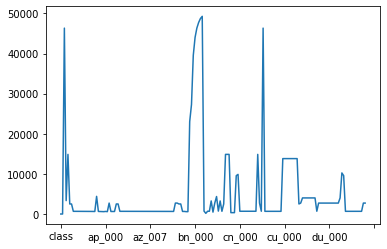

In [11]:
df_train.isnull().sum().plot()

Çok fazla boş değere sahip olan attributeları kaldıralım.

In [12]:
row_len = df_train.shape[0]
df_train = df_train[df_train.columns[df_train.isnull().sum() < (row_len*0.2)]]
df_test = df_test[df_train.columns]

Geri kalan boş değerleri o sütunun ortalaması ile dolduralım.

In [13]:
df_train = df_train.fillna(df_train.mean())
df_test = df_test.fillna(df_test.mean())

Verisiz alanlardan kurtulmuş olduk

<AxesSubplot:>

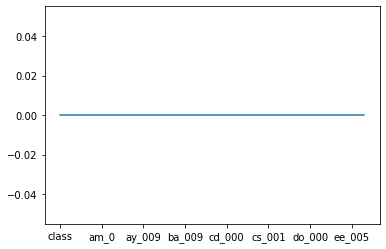

In [14]:
df_train.isnull().sum().plot()

# Veri Bölümü

Verilerimizi x ve y olarak bölelim. Train ve Test örneklerimiz farklı dosyalarda olduğu için split işlemi yapmamıza gerek kalmadı.

In [15]:
x_train = df_train[df_train.columns[1:]]
y_train = df_train[df_train.columns[0]]
y_train = y_train.replace('neg', 0)
y_train = y_train.replace('pos', 1)

In [16]:
x_test = df_test[df_test.columns[1:]]
y_test = df_test[df_test.columns[0]]
y_test = y_test.replace('neg', 0)
y_test = y_test.replace('pos', 1)

In [17]:
x_train.columns

Index(['aa_000', 'ac_000', 'ae_000', 'af_000', 'ag_000', 'ag_001', 'ag_002',
       'ag_003', 'ag_004', 'ag_005',
       ...
       'ee_002', 'ee_003', 'ee_004', 'ee_005', 'ee_006', 'ee_007', 'ee_008',
       'ee_009', 'ef_000', 'eg_000'],
      dtype='object', length=146)

# Feature Seçimi

Veri setine baktığımız zaman çok fazla attribute var. Bunların çoğu da anlamlı bilgi içermektedir. Anlamlı verininde etkisini azaltmaktadır. Bunları saptamamız lazım.

In [18]:
feature_select = SelectKBest(score_func=f_classif, k='all')
feature_select.fit(x_train, y_train)

c:\users\dodo\appdata\local\programs\python\python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [79] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
c:\users\dodo\appdata\local\programs\python\python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


SelectKBest(k='all')

Grafikte hangi numaralı özelliklerin daha etkili olduğu görebilmekteyiz. Buna uygun bir eşik değeri belirleyip bazılarını çıkartmamız modelimizin başarsını artıracaktır.

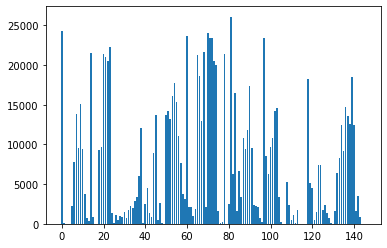

In [19]:
plt.bar([i for i in range(len(feature_select.scores_))], feature_select.scores_)
plt.show()

Eşik değerini grafik yardımı ile 5000 belirledikten sonra bu değerin altında kalan sütunları kaldırıyoruz.

In [20]:
threshold = 5000 
remove_cols = []
for i in range(0, len(feature_select.scores_)):
    if(feature_select.scores_[i] < threshold):
        remove_cols.append(x_train.columns[i])

In [21]:
x_train.drop(remove_cols, axis=1, inplace=True)
x_test.drop(remove_cols, axis=1, inplace=True)

c:\users\dodo\appdata\local\programs\python\python39\lib\site-packages\pandas\core\frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


# Outlier Analizi

Başlangıçta Train veri sayımız 60000.

In [22]:
x_train.shape[0], y_train.shape[0]

(60000, 60000)

Boxplot ve Zscore yöntemlerini denedim. Çok fazla veri kaybı yaşadım. Çünkü bu yöntemler global olarak outlier analizi yapıyor. Veri setimde ise çok fazla local maksimumlar mevcut. Bu nedenle LocalOutlier analizi ile yakın komşuları arasındaki ilişkiye bakarak tespit etmek çok daha verimli sonuç verdi.

In [23]:
lof = LocalOutlierFactor(n_neighbors=3)
yhat = lof.fit_predict(x_train)
mask = yhat != -1
x_train.shape[0], y_train.shape[0]
x_train, y_train = x_train[mask], y_train[mask]

Outlier çıkarıldıktan sonra Train veri sayımız.

In [24]:
x_train.shape[0], y_train.shape[0]

(57699, 57699)

#  &&&&&&&&&&&&&&&& Sınıflama Algoritmaları &&&&&&&&&&&&&&&&&&

#  --------------------------------------------SGDClassifier---------------------------------------------

Supervised sınıflandırma algoritması olan SGD Classifier bir doğrusal sınıflayıcıdır. Stokastik gradyan kullanır. Stokastik gradyan inişi, tüm eğitim verilerini dikkate alan gradyan inişinden farklı olarak ağırlıkları değiştirirken yalnızca 1 rastgele noktayı dikkate alır. Bu tür stokastik gradyan inişi, büyük veri setleriyle uğraşırken gradyan inişinden çok daha hızlıdır.

# Model oluşturma ve eğitim

In [25]:
clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=1000)
clf.fit(x_train, y_train)

SGDClassifier()

# Test Verisinin Tahmini

In [26]:
y_predict = clf.predict(x_test)
y_predict

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

# Confusion Matrix

In [27]:
cm = confusion_matrix(y_test, y_predict)
df_cm = pd.DataFrame(cm, index=['pos', 'neg'], columns=['True', 'False'])

Verimizde negatif örneğin çok daha fazla olmasından dolayı dengesiz bir dağılım var.

array([[15581,    44],
       [  145,   230]], dtype=int64)

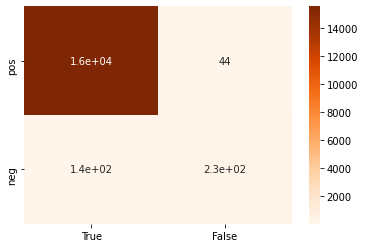

In [28]:
ax = sn.heatmap(df_cm, cmap='Oranges', annot=True)
cm

# Accuracy

In [29]:
accuracy = accuracy_score(y_test, y_predict)     
accuracy

0.9881875

#  -------------------------------Complement NaiveBayes--------------------------------------

ComplementNB, tamamlayıcı saf Bayes (CNB) algoritmasını uygular. CNB, özellikle dengesiz veri kümeleri için uygun olan standart multinomial Naive Bayes (MNB) algoritmasının bir uyarlamasıdır. CNB, modelin ağırlıklarını hesaplamak için özellikle her sınıfın tamamlayıcısından elde edilen istatistikleri kullanır. 


# Model oluşturma ve eğitim

In [30]:
clf2 = ComplementNB()
clf2.fit(x_train, y_train)

ComplementNB()

# Test Verisinin Tahmini

In [31]:
y2_predict = clf2.predict(x_test)
y2_predict

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

# Confusion Matrix

array([[14756,   869],
       [  112,   263]], dtype=int64)

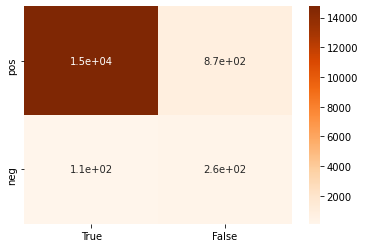

In [32]:
cm2 = confusion_matrix(y_test, y2_predict)
df_cm2 = pd.DataFrame(cm2, index=['pos', 'neg'], columns=['True', 'False'])
ax = sn.heatmap(df_cm2, cmap='Oranges', annot=True)
cm2

# Accuracy

In [33]:
accuracy2 = accuracy_score(y_test, y2_predict)
accuracy2

0.9386875

#  ---------------------------------KNeighbors Classifier----------------------------------------

K-NN ( K-Nearest Neighbor) algoritması en basit ve en çok kullanılan sınıflandırma algoritmasından biridir. K-NN non-parametric ( parametrik olmayan ), lazy ( tembel ) bir öğrenme algoritmasıdır. lazy kavramını anlamaya çalışırsak eager learning aksine lazy learning’in bir eğitim aşaması yoktur. Eğitim verilerini öğrenmez, bunun yerine eğitim veri kümesini “ezberler”. Bir tahmin yapmak istediğimizde, tüm veri setinde en yakın komşuları arar.

# Model oluşturma ve eğitim

In [34]:
clf3 = KNeighborsClassifier(n_neighbors=3)
clf3.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=3)

# Test Verisinin Tahmini

In [35]:
y3_predict = clf3.predict(x_test)
y3_predict

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

# Confusion Matrix

array([[15571,    54],
       [  178,   197]], dtype=int64)

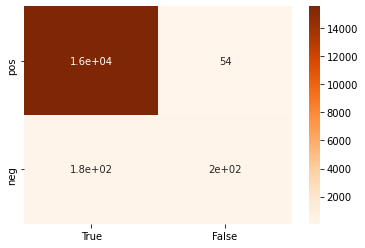

In [36]:
cm3 = confusion_matrix(y_test, y3_predict)
df_cm3 = pd.DataFrame(cm3, index=['pos', 'neg'], columns=['True', 'False'])
ax = sn.heatmap(df_cm3, cmap='Oranges', annot=True)
cm3

# Accuracy

In [37]:
accuracy3 = accuracy_score(y_test, y3_predict)
accuracy3

0.9855

# -----------------------Sınıflandırma Algoritmalarını karşılaştırma-----------------------

SGDClassifier, Complement NaiveBayes ve KNeighbors olmak üzere 3 tane sınıflandırma algoritması çalıştırdık. 

# Accuracy olarak bakarsak.

In [38]:
accuracy, accuracy2, accuracy3

(0.9881875, 0.9386875, 0.9855)

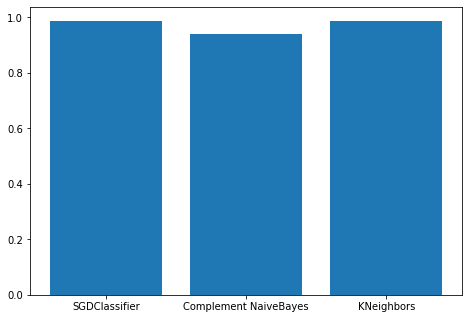

In [39]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(['SGDClassifier', 'Complement NaiveBayes', 'KNeighbors'],[accuracy, accuracy2, accuracy3])
plt.show()

SGDClassifier > KNeighbors > Complement NaiveBayes olarak sıralanmaktadır. Ama veri setimizde 59000 negatif kısma 1000 tane pozitif kısma ait veri olduğu için hepsini negatif seçsek bile accuracy yüksekmiş gibi durucak. Bu yüzden accuracy den çok veri setimizin açıklamasında da bahsedilen cost denklemini kullanalım.

# Total cost = NTx500 + PNx10

# Confusion Matrix olarak bakarsak.

Her yöntemin costunu hesaplayacağız. Ne kadar az ise o kadar iyi sonuç elde etmiş demektir.

SGDClassifier'ın costu

In [40]:
cost1 = cm[0][1]*10 + cm[1][0]*500
cost1

72940

Complement NaiveBayes'ın costu

In [41]:
cost2 = cm2[0][1]*10 + cm2[1][0]*500
cost2

64690

KNeighbors'ın costu

In [42]:
cost3 = cm3[0][1]*10 + cm3[1][0]*500
cost3

89540

Cost değerleri. Az olan daha iyi.

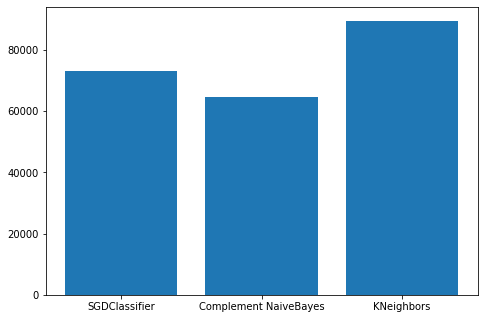

In [43]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(['SGDClassifier', 'Complement NaiveBayes', 'KNeighbors'],[cost1, cost2, cost3])
plt.show()

# Precision

Text(0.5, 1.0, 'SGDClassifier Precision-Recall curve ')

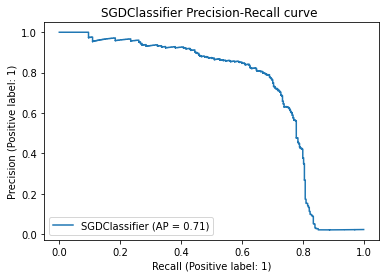

In [44]:
disp = plot_precision_recall_curve(clf, x_test, y_test)
disp.ax_.set_title('SGDClassifier Precision-Recall curve ')

Text(0.5, 1.0, 'Complement NaiveBayes Precision-Recall curve')

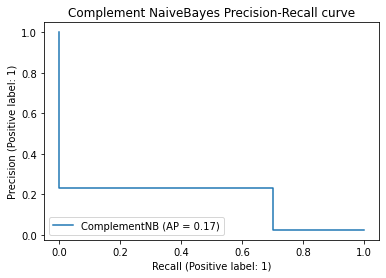

In [45]:
disp = plot_precision_recall_curve(clf2, x_test, y_test)
disp.ax_.set_title('Complement NaiveBayes Precision-Recall curve')

Text(0.5, 1.0, 'KNeighbors Precision-Recall curve')

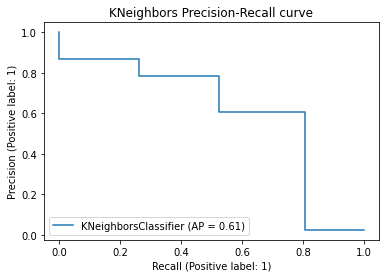

In [46]:
disp = plot_precision_recall_curve(clf3, x_test, y_test)
disp.ax_.set_title('KNeighbors Precision-Recall curve')

# F1 Score

In [47]:
f1_score_clf = f1_score(y_test, y_predict, average='weighted')
print("SGDCLassifier'ın f1 score : ", f1_score_clf)

SGDCLassifier'ın f1 score :  0.9872873730346972


In [48]:
f1_score_clf2 = f1_score(y_test, y2_predict, average='weighted')
print("Complement NaiveBayes'ın f1 score : ", f1_score_clf2)

Complement NaiveBayes'ın f1 score :  0.953325771246443


In [49]:
f1_score_clf3 = f1_score(y_test, y3_predict, average='weighted')
print("KNeighbors'ın f1 score : ", f1_score_clf3)

KNeighbors'ın f1 score :  0.9840925520633168


#  &&&&&&&&&&&&&&& Kümeleme Algoritmaları &&&&&&&&&&&&&&&&&

#  --------------------------------------------KMeans----------------------------------------------

K-ortalama kümeleme ya da K-means kümeleme (K-means clustering) yöntemi N adet veri nesnesinden oluşan bir veri kümesini giriş parametresi olarak verilen K adet kümeye bölümlemektir. Amaç, gerçekleştirilen bölümleme işlemi sonunda elde edilen kümelerin, küme içi benzerliklerinin maksimum ve kümeler arası benzerliklerinin ise minimum olmasını sağlamaktır. 

# Model oluşturma ve eğitim

Veri setimizde 'pos' ve 'neg' olmak üzere 2 farklı grup var. 

In [50]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(x_train)

# Test Verisinin Tahmini

In [51]:
y_cls_predict = kmeans.predict(x_test)
y_cls_predict

array([0, 0, 0, ..., 0, 0, 0])

# Confusion Matrix

array([[15346,   279],
       [  105,   270]], dtype=int64)

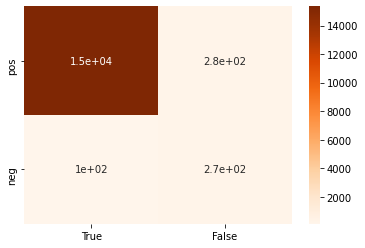

In [52]:
cm_cls = confusion_matrix(y_test, y_cls_predict)
df_cm_cls = pd.DataFrame(cm_cls, index=['pos', 'neg'], columns=['True', 'False'])
ax = sn.heatmap(df_cm_cls, cmap='Oranges', annot=True)
cm_cls

# Accuracy

In [53]:
accuracy_cls = accuracy_score(y_test, y_cls_predict)
accuracy_cls

0.976

# Dağılım

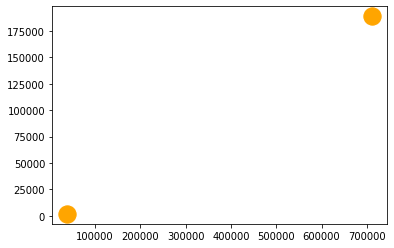

In [54]:
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='orange', label = 'Centroids')
plt.show()

#  ----------------------------------Agglomerative Clustering------------------------------------

Aglomeratif kümeleme, kümelerdeki nesneleri benzerliklerine göre gruplamak için kullanılan en yaygın hiyerarşik kümeleme türüdür. AGNES (Aglomerative Nesting) olarak da bilinir. Algoritma, her nesneyi tek bir küme olarak ele alarak başlar. Daha sonra, küme çiftleri, tüm kümeler tüm nesneleri içeren büyük bir kümede birleştirilene kadar art arda birleştirilir. Sonuç, dendrogram adlı nesnelerin ağaç temelli bir temsilidir.

# Model oluşturma ve test

In [55]:
cls2 = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
y2_cls_predict = cls2.fit_predict(x_test)
y2_cls_predict

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

# Dendrogram görünümü

Text(0.5, 0, 'Number of points in node (or index of point if no parenthesis).')

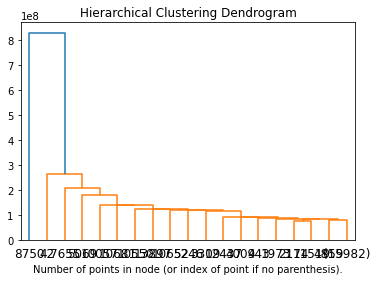

In [56]:
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = linkage(x_test)
    dendrogram(linkage_matrix, **kwargs)

plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(cls2, truncate_mode='level', p=16)                          
plt.xlabel("Number of points in node (or index of point if no parenthesis).")

# Accuracy

In [57]:
accuracy2_cls = accuracy_score(y_test, y2_cls_predict)
accuracy2_cls

0.9789375

# Confusion Matrix

array([[15502,   123],
       [  214,   161]], dtype=int64)

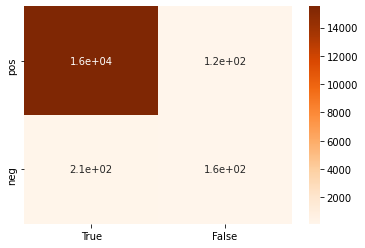

In [58]:
cm2_cls = confusion_matrix(y_test, y2_cls_predict)
df_cm2_cls = pd.DataFrame(cm2_cls, index=['pos', 'neg'], columns=['True', 'False'])
ax = sn.heatmap(df_cm2_cls, cmap='Oranges', annot=True)
cm2_cls

#  ------------------------------------------BIRCH-------------------------------------------

MiniBatchKMeans'e alternatif olarak sağlanan, bellek açısından verimli, çevrimiçi öğrenme algoritmasıdır. Yapraktan okunan küme ağırlık merkezleriyle bir ağaç veri yapısı oluşturur. Bunlar, son küme merkezleri olabilir veya AglomerativeClustering gibi başka bir kümeleme algoritmasına girdi olarak sağlanabilir.

# Model oluşturma ve test

In [59]:
cls3 = Birch(n_clusters=2)
cls3.fit(x_test)
y3_cls_predict = cls3.predict(x_test)

# Confusion Matrix

array([[15502,   123],
       [  214,   161]], dtype=int64)

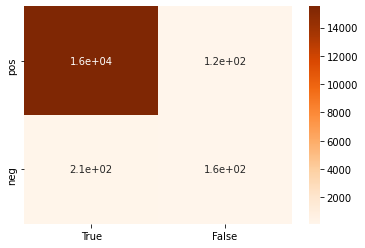

In [60]:
cm3_cls = confusion_matrix(y_test, y3_cls_predict)
df_cm3_cls = pd.DataFrame(cm3_cls, index=['pos', 'neg'], columns=['True', 'False'])
ax = sn.heatmap(df_cm3_cls, cmap='Oranges', annot=True)
cm3_cls

# Accuracy

In [61]:
accuracy3_cls = accuracy_score(y_test, y3_cls_predict)
accuracy3_cls

0.9789375

# -----------------------Kümeleme Algoritmalarını karşılaştırma-----------------------

# Accuracy olarak bakarsak.

Çok az bir farkla BIRCH ve Agglomerative Clustering daha iyi sonuç verdi.

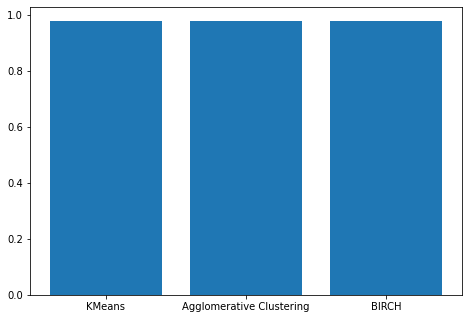

(0.976, 0.9789375, 0.9789375)

In [62]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(['KMeans', 'Agglomerative Clustering', 'BIRCH'],[accuracy_cls, accuracy2_cls, accuracy3_cls])
plt.show()
accuracy_cls, accuracy2_cls, accuracy3_cls

Ama veri setimizde 59000 negatif kısma 1000 tane pozitif kısma ait veri olduğu için hepsini negatif seçsek bile accuracy yüksekmiş gibi durucak. Bu yüzden accuracy den çok veri setimizin açıklamasında da bahsedilen cost denklemini kullanalım.

# Total cost = NTx500 + PNx10

# Confusion Matrix olarak bakarsak.

In [63]:
cost1 = cm_cls[0][1]*10 + cm_cls[1][0]*500
cost1

55290

In [64]:
cost2 = cm2_cls[0][1]*10 + cm2_cls[1][0]*500
cost2

108230

In [65]:
cost3 = cm3_cls[0][1]*10 + cm3_cls[1][0]*500
cost3

108230

Cost değerlerini görüyoruz. Düşük olan daha iyi olduğu için Kmeans daha iyi sonuç verdiğini söyleyebiliriz.

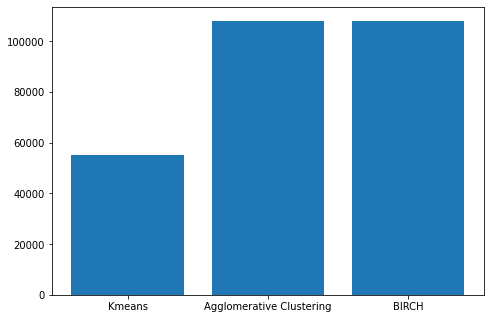

In [66]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(['Kmeans', 'Agglomerative Clustering', 'BIRCH'],[cost1, cost2, cost3])
plt.show()

# Presicion, Recall, Fscore, Support

In [67]:
precision, recall, fscore, support = score(y_test, y_cls_predict)
print("KMeans ")
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

KMeans 
precision: [0.99320432 0.49180328]
recall: [0.982144 0.72    ]
fscore: [0.9876432  0.58441558]
support: [15625   375]


In [68]:
precision, recall, fscore, support = score(y_test, y2_cls_predict)
print("Agglomerative Clustering ")
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

Agglomerative Clustering 
precision: [0.9863833  0.56690141]
recall: [0.992128   0.42933333]
fscore: [0.98924731 0.48861912]
support: [15625   375]


In [69]:
precision, recall, fscore, support = score(y_test, y3_cls_predict)
print("BIRCH ")
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

BIRCH 
precision: [0.9863833  0.56690141]
recall: [0.992128   0.42933333]
fscore: [0.98924731 0.48861912]
support: [15625   375]


#  &&&&&&&&&&&&&&& Genel Sonuç &&&&&&&&&&&&&&&&&

Genel olarak en iyi sonucu SGDClassifier'ın verdiğini söyleyebiliriz. Supervised ve tembel olmayan bir öğrenim yaptığından dolayı bu veri setinde doğal olarak kümeleme algoritmalarına karşı daha iyi sonuçlar verdi. Veri sayımızın yüksek olması SGDClassifier algoritmalarının daha iyi sonuçlar vermesini sağladı. Precision ve f1score olarakta en iyi sayılar SGDCLassifier'a ait.